In [2]:
import pandas as pd

In [4]:
emojis = pd.read_csv("/content/drive/MyDrive/emojis.csv")

In [5]:
emojis

,text,emoji
0,@ATLHawks: Chance The Rapper or Kent Bazemore?...,🤔
1,"@nice_aju: Yup we love you, you're so precious...",💙
2,Fav Sing Me to Sleep by Alan Walker,💛
3,@AshBenzo: Wife From The Real-Life 'Fault In O...,💔
4,Why am I up so late,😔
...,...,...
806198,@FunnyPicsDepot: When your mama about to whoop...,😂
806199,@v2weekx: @AstralWench @A_DVS_NTT You both are...,❤
806200,@Trekles: Best video on Twitter still,😂
806201,@isamarbabii07: @Sammiee_x3 Seriously so annoy...,😂


In [6]:
TOTAL_COUNT = emojis['emoji'].count()

In [86]:
emojis['emoji'].value_counts()[:10]

😂    124823
❤     43218
😍     40566
😭     35714
😊     20076
🙄     17963
😩     16232
🔥     15453
🤔     15419
💕     12026
Name: emoji, dtype: int64

In [11]:
TOP_FRACTION = 0.75

In [12]:
count = 0
top_emojis = set()
for index, value in emojis['emoji'].value_counts().iteritems():
  if count < TOP_FRACTION * TOTAL_COUNT:
    count += value
    top_emojis.add(index)

In [13]:
len(top_emojis)

63

In [14]:
filtered_emojis = emojis[emojis['emoji'].isin(top_emojis)]

In [15]:
len(emojis), len(filtered_emojis)

(806203, 605230)

In [16]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.layers import MaxPool1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [17]:
# make the max word length to be constant
MAX_WORDS = 5000
MAX_SEQUENCE_LENGTH = 100
# the percentage of train test split to be applied
VALIDATION_SPLIT = 0.20
# the dimension of vectors to be used
EMBEDDING_DIM = 100
EMOJIS_COUNT = len(top_emojis)
# filter sizes of the different conv layers 
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100
# dropout probability
drop = 0.2
batch_size = 30
epochs = 3

In [18]:
EMOJIS_COUNT

63

# Данные несбалансированы - проведем балансировку датасета 

In [22]:
from imblearn.under_sampling import RandomUnderSampler

random_under_sampler = RandomUnderSampler(random_state=42)
X_us, y_us = random_under_sampler.fit_resample(filtered_emojis[['text']], filtered_emojis['emoji'])

print('Dataset Size:', len(X_us))

Dataset Size: 175392


In [28]:
for emoji in y_us[:3]:
  print(emoji)

©
©
©


In [25]:
texts = []
X_us['text'].apply(lambda t: texts.append(t))

0         None
1         None
2         None
3         None
4         None
          ... 
175387    None
175388    None
175389    None
175390    None
175391    None
Name: text, Length: 175392, dtype: object

In [29]:
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids

for emoji in y_us:
    if emoji in labels_index:
        label_id = labels_index[emoji]
    else:
        label_id = len(labels_index)
        labels_index[emoji] = label_id
    labels.append(label_id)

In [30]:
tokenizer  = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(texts)
sequences =  tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

unique words : 154645


In [31]:
import numpy as np

In [32]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (175392, 100)
Shape of label tensor: (175392, 63)


In [33]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [ ]:
# !wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

In [ ]:
# !unzip glove.twitter.27B.zip

In [ ]:
# !cp glove.twitter.27B.100d.txt /content/drive/MyDrive/

In [34]:
embeddings_index = {}
with open('/content/drive/MyDrive/glove.twitter.27B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [35]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [36]:
embedding_matrix.shape

(154646, 100)

In [37]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [38]:
inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding = embedding_layer(inputs)

print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, 1))(embedding)
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=EMOJIS_COUNT, activation='softmax')(dropout)

# this creates a model that includes
model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights_cnn_sentece.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

(None, 100, 100)
(None, 100, 100, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 100)     15464600    ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 100, 100, 1)  0           ['embedding[0][0]']              
                                                                                                  
 conv2d (Conv2D)                (None, 98, 1, 512)   154112      ['reshape[0][0]']                
                                                         

In [85]:
print("Traning Model...")
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=10, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))

Traning Model...
Epoch 1/10
4678/4678 [==============================] - 152s 32ms/step - loss: 2.3235 - accuracy: 0.4089 - val_loss: 3.1190 - val_accuracy: 0.2620
Epoch 2/10
4678/4678 [==============================] - 151s 32ms/step - loss: 2.2832 - accuracy: 0.4191 - val_loss: 3.1250 - val_accuracy: 0.2628
Epoch 3/10
4678/4678 [==============================] - 150s 32ms/step - loss: 2.2431 - accuracy: 0.4280 - val_loss: 3.1374 - val_accuracy: 0.2636
Epoch 4/10
4678/4678 [==============================] - 150s 32ms/step - loss: 2.2057 - accuracy: 0.4358 - val_loss: 3.1350 - val_accuracy: 0.2650
Epoch 5/10
4678/4678 [==============================] - 150s 32ms/step - loss: 2.1708 - accuracy: 0.4427 - val_loss: 3.1479 - val_accuracy: 0.2661
Epoch 6/10
4678/4678 [==============================] - 151s 32ms/step - loss: 2.1365 - accuracy: 0.4517 - val_loss: 3.1658 - val_accuracy: 0.2661
Epoch 7/10
4678/4678 [==============================] - 151s 32ms/step - loss: 2.1015 - accuracy: 0.4

In [42]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


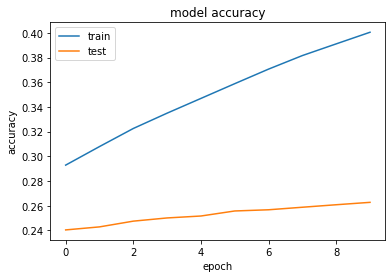

In [84]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [81]:
sequences =  tokenizer.texts_to_sequences(["hate you so much"])
query = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
output = model.predict(query)
label_id = np.argmax(output)

In [82]:
for e, v in labels_index.items():
  if v == label_id:
    print(e)

💔


In [83]:
model.save("kaggle_model_63")

INFO:tensorflow:Assets written to: kaggle_model_63/assets
